In [2]:
!pip install pybioclip pyinaturalist --quiet
from pyinaturalist import get_observations, Observation
import os
import io
import pandas as pd
from bioclip import TreeOfLifeClassifier, Rank
import requests
from PIL import Image, UnidentifiedImageError
import tempfile
import numpy as np


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 7.7 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

open_clip_config.json:   0%|          | 0.00/469 [00:00<?, ?B/s]

txt_emb_species.npy:   0%|          | 0.00/787M [00:00<?, ?B/s]

txt_emb_species.json:   0%|          | 0.00/65.7M [00:00<?, ?B/s]

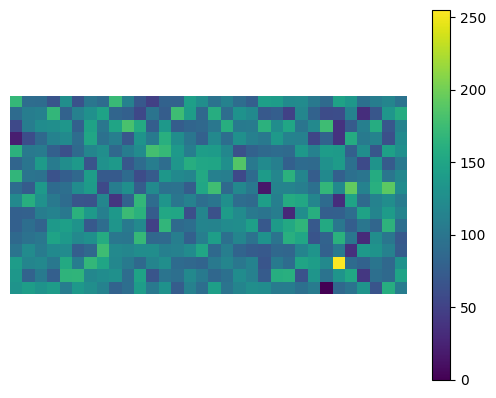

In [3]:
import torch
import numpy as np
import requests
from PIL import Image
import io
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms

# Function to preprocess the image
def preprocess_image(image):
    preprocess = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image_tensor = preprocess(image).unsqueeze(0)
    return image_tensor

# Function to visualize the feature vector (flattened)
def visualize_clip_features(feature_vector):
    # Reshape to a 2D matrix (e.g., 16x32) for visualization, or just use it directly
    feature_map = feature_vector.view(16, 32).cpu().numpy()  # Reshape to 16x32 for visualization

    # Normalize for visualization
    feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())
    feature_map = np.uint8(255 * feature_map)

    plt.imshow(feature_map, cmap='viridis')
    plt.colorbar()
    plt.axis('off')
    plt.show()

# Example usage with CLIP model
classifier = TreeOfLifeClassifier()  # Your model
image_url = 'https://zoomed.com/wp-content/uploads/Blue-Death-Feigning-Beetles-9873b.jpg'
response = requests.get(image_url)
img = Image.open(io.BytesIO(response.content))

input_tensor = preprocess_image(img)

with torch.no_grad():
    feature_vector = classifier.model.encode_image(input_tensor)[0]  # Extract the first feature vector

visualize_clip_features(feature_vector)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


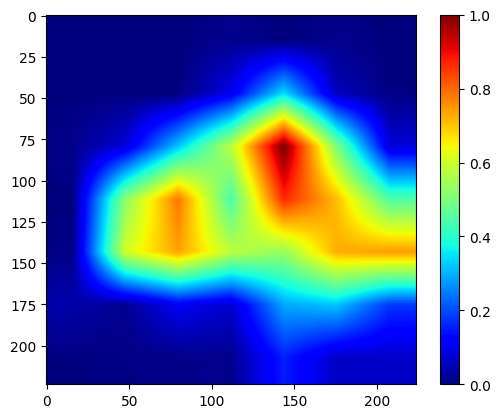

In [6]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision.models import resnet50

# Hook to capture gradients
def hook_gradients(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0]

# Hook to capture activations
def hook_activations(module, input, output):
    global activations
    activations = output

# Define the Grad-CAM function
def generate_gradcam_heatmap(model, image_tensor, target_layer_name):
    global gradients, activations
    model.eval()

    # Register hooks
    hooks = []
    for name, module in model.named_modules():
        if name == target_layer_name:
            hooks.append(module.register_forward_hook(hook_activations))
            hooks.append(module.register_backward_hook(hook_gradients))

    # Ensure the input tensor requires gradients
    image_tensor.requires_grad_()

    # Forward pass
    output = model(image_tensor)

    # Zero out gradients
    model.zero_grad()

    # Target class (for simplicity, we use the highest score)
    target_class = output.argmax()

    # Backward pass
    output[0, target_class].backward()

    # Remove hooks
    for hook in hooks:
        hook.remove()

    # Pool gradients
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # Weight feature maps
    for i in range(pooled_gradients.size(0)):
        activations[:, i, :, :] *= pooled_gradients[i]

    # Average feature maps and apply ReLU
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap.cpu().detach().numpy(), 0)
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = heatmap / np.max(heatmap)

    return heatmap

# Example usage
model = models.resnet50(weights='DEFAULT')  # Updated to use 'weights' argument
image_url = 'https://zoomed.com/wp-content/uploads/Blue-Death-Feigning-Beetles-9873b.jpg'
response = requests.get(image_url)
img = Image.open(io.BytesIO(response.content))

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(img).unsqueeze(0)

heatmap = generate_gradcam_heatmap(model, input_tensor, target_layer_name='layer4')

plt.imshow(heatmap, cmap='jet')
plt.colorbar()
plt.show()


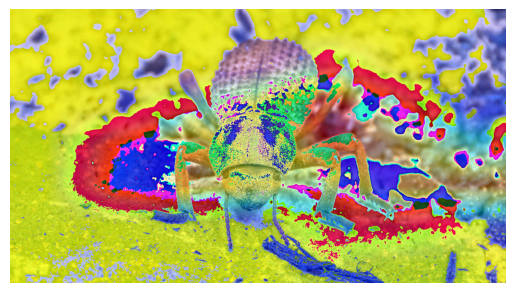

In [12]:
#with original background
import torch
import numpy as np
import cv2
import requests
import io
from PIL import Image
from torchvision import transforms, models
from torch.autograd import Variable
from torchvision.models import resnet50

# Hook to capture gradients
def hook_gradients(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0]

# Hook to capture activations
def hook_activations(module, input, output):
    global activations
    activations = output

# Define the Grad-CAM function
def generate_gradcam_heatmap(model, image_tensor, target_layer_name):
    global gradients, activations
    model.eval()

    # Register hooks
    hooks = []
    for name, module in model.named_modules():
        if name == target_layer_name:
            hooks.append(module.register_forward_hook(hook_activations))
            hooks.append(module.register_backward_hook(hook_gradients))

    # Ensure the input tensor requires gradients
    image_tensor.requires_grad_()

    # Forward pass
    output = model(image_tensor)

    # Zero out gradients
    model.zero_grad()

    # Target class (for simplicity, we use the highest score)
    target_class = output.argmax()

    # Backward pass
    output[0, target_class].backward()

    # Remove hooks
    for hook in hooks:
        hook.remove()

    # Pool gradients
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # Weight feature maps
    for i in range(pooled_gradients.size(0)):
        activations[:, i, :, :] *= pooled_gradients[i]

    # Average feature maps and apply ReLU
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap.cpu().detach().numpy(), 0)
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = heatmap / np.max(heatmap)

    return heatmap

# Example usage
model = models.resnet50(weights='DEFAULT')  # Updated to use 'weights' argument
image_url = 'https://zoomed.com/wp-content/uploads/Blue-Death-Feigning-Beetles-9873b.jpg'
response = requests.get(image_url)
img = Image.open(io.BytesIO(response.content))

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(img).unsqueeze(0)

heatmap = generate_gradcam_heatmap(model, input_tensor, target_layer_name='layer4')

# Convert the PIL image to a numpy array and ensure it's in uint8 format
img_cv = np.array(img)
if img_cv.dtype != np.uint8:
    img_cv = img_cv.astype(np.uint8)

# Resize the heatmap to match the original image dimensions
heatmap = cv2.resize(heatmap, (img_cv.shape[1], img_cv.shape[0]))

# Normalize and apply color map
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Superimpose heatmap on the original image
superimposed_img = heatmap * 0.4 + img_cv

# Ensure the superimposed image is in uint8 format
superimposed_img = np.uint8(superimposed_img)

# Save the resulting image
cv2.imwrite('./map.jpg', superimposed_img)

# Display the resulting image
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


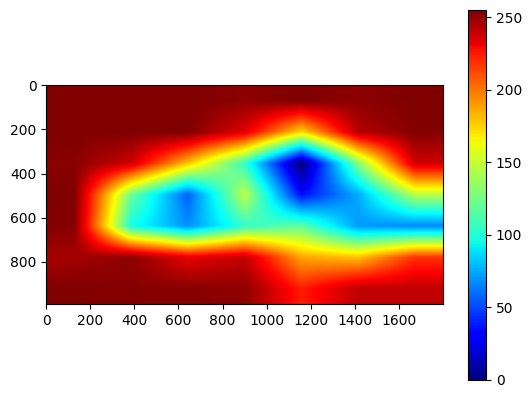

In [13]:
plt.imshow(heatmap, cmap='jet')
plt.colorbar()
plt.show()

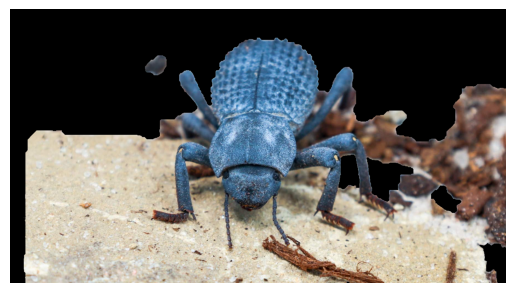

In [14]:
#draft_segmentation #for trail only
import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt

# Download image from URL
url = "https://zoomed.com/wp-content/uploads/Blue-Death-Feigning-Beetles-9873b.jpg"
resp = urllib.request.urlopen(url)
image = np.asarray(bytearray(resp.read()), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_COLOR)

# Convert to RGB (from BGR used by OpenCV)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Initialize mask
mask = np.zeros(image_rgb.shape[:2], np.uint8)

# Define the background and foreground models
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

# Define a rectangle around the object you want to segment (adjust these values)
rect = (50, 50, image_rgb.shape[1] - 50, image_rgb.shape[0] - 50)

# Apply grabCut algorithm
cv2.grabCut(image_rgb, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

# Modify the mask to set the background to 0 and the foreground to 1
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

# Apply the mask to the image
image_rgb_nobg = image_rgb * mask2[:, :, np.newaxis]

# Display the result
plt.imshow(image_rgb_nobg)
plt.axis('off')
plt.show()


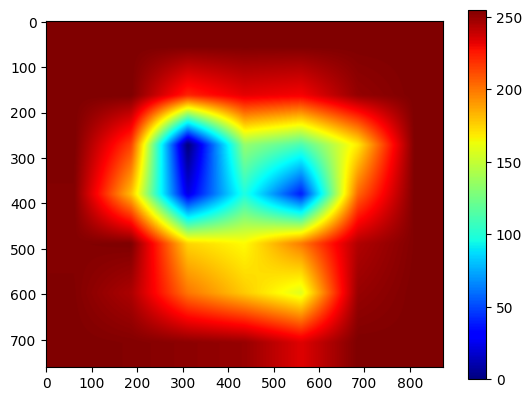

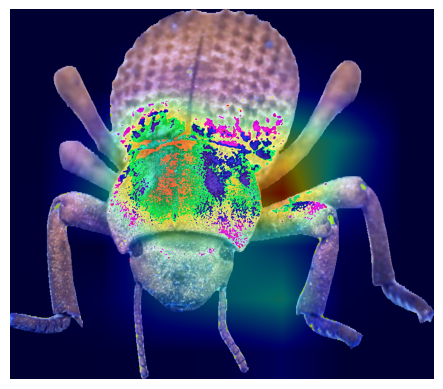

In [17]:
#after removing background
import torch
import numpy as np
import cv2
import requests
import io
from PIL import Image
from torchvision import transforms, models
from torch.autograd import Variable
from torchvision.models import resnet50
import matplotlib.pyplot as plt

# Hook to capture gradients
def hook_gradients(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0]

# Hook to capture activations
def hook_activations(module, input, output):
    global activations
    activations = output

# Define the Grad-CAM function
def generate_gradcam_heatmap(model, image_tensor, target_layer_name):
    global gradients, activations
    model.eval()

    # Register hooks
    hooks = []
    for name, module in model.named_modules():
        if name == target_layer_name:
            hooks.append(module.register_forward_hook(hook_activations))
            hooks.append(module.register_backward_hook(hook_gradients))

    # Ensure the input tensor requires gradients
    image_tensor.requires_grad_()

    # Forward pass
    output = model(image_tensor)

    # Zero out gradients
    model.zero_grad()

    # Target class (for simplicity, we use the highest score)
    target_class = output.argmax()

    # Backward pass
    output[0, target_class].backward()

    # Remove hooks
    for hook in hooks:
        hook.remove()

    # Pool gradients
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # Weight feature maps
    for i in range(pooled_gradients.size(0)):
        activations[:, i, :, :] *= pooled_gradients[i]

    # Average feature maps and apply ReLU
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap.cpu().detach().numpy(), 0)
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = heatmap / np.max(heatmap)

    return heatmap

# Example usage
model = models.resnet50(weights='DEFAULT')  # Updated to use 'weights' argument

# Convert Google Drive link to direct download link
image_url = 'https://drive.google.com/uc?id=1IcAHK7DpKro_yfae0PFy0jTQe1bAuZqn'
response = requests.get(image_url)
img = Image.open(io.BytesIO(response.content))

# Convert image to RGB if it's in RGBA format
if img.mode == 'RGBA':
    img = img.convert('RGB')

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(img).unsqueeze(0)

heatmap = generate_gradcam_heatmap(model, input_tensor, target_layer_name='layer4')

# Convert the PIL image to a numpy array and ensure it's in uint8 format
img_cv = np.array(img)
if img_cv.dtype != np.uint8:
    img_cv = img_cv.astype(np.uint8)

# Resize the heatmap to match the original image dimensions
heatmap = cv2.resize(heatmap, (img_cv.shape[1], img_cv.shape[0]))

# Normalize and apply color map
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Superimpose heatmap on the original image
superimposed_img = heatmap * 0.4 + img_cv

# Ensure the superimposed image is in uint8 format
superimposed_img = np.uint8(superimposed_img)

# Save the resulting image
cv2.imwrite('./map.jpg', superimposed_img)

# Display the heat map
plt.imshow(heatmap, cmap='jet')
plt.colorbar()
plt.show()

# Display the resulting image
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


Predicted class: ground beetle (index 302)


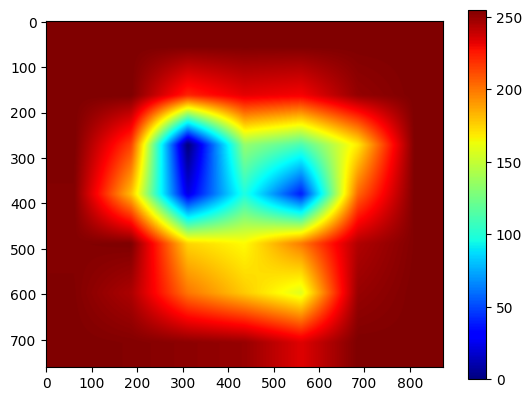

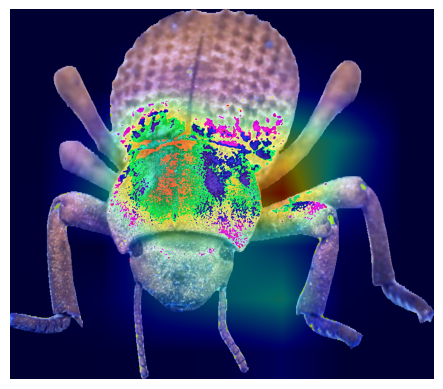

In [18]:
import torch
import numpy as np
import cv2
import requests
import io
from PIL import Image
from torchvision import transforms, models
from torch.autograd import Variable
from torchvision.models import resnet50
import matplotlib.pyplot as plt

# Hook to capture gradients
def hook_gradients(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0]

# Hook to capture activations
def hook_activations(module, input, output):
    global activations
    activations = output

# Define the Grad-CAM function
def generate_gradcam_heatmap(model, image_tensor, target_layer_name):
    global gradients, activations
    model.eval()

    # Register hooks
    hooks = []
    for name, module in model.named_modules():
        if name == target_layer_name:
            hooks.append(module.register_forward_hook(hook_activations))
            hooks.append(module.register_backward_hook(hook_gradients))

    # Ensure the input tensor requires gradients
    image_tensor.requires_grad_()

    # Forward pass
    output = model(image_tensor)

    # Zero out gradients
    model.zero_grad()

    # Target class (for simplicity, we use the highest score)
    target_class = output.argmax()

    # Backward pass
    output[0, target_class].backward()

    # Remove hooks
    for hook in hooks:
        hook.remove()

    # Pool gradients
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # Weight feature maps
    for i in range(pooled_gradients.size(0)):
        activations[:, i, :, :] *= pooled_gradients[i]

    # Average feature maps and apply ReLU
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap.cpu().detach().numpy(), 0)
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = heatmap / np.max(heatmap)

    return heatmap

# Load the model with pretrained weights
model = models.resnet50(weights='DEFAULT')  # Updated to use 'weights' argument

# Convert Google Drive link to direct download link
image_url = 'https://drive.google.com/uc?id=1IcAHK7DpKro_yfae0PFy0jTQe1bAuZqn'
response = requests.get(image_url)
img = Image.open(io.BytesIO(response.content))

# Convert image to RGB if it's in RGBA format
if img.mode == 'RGBA':
    img = img.convert('RGB')

# Preprocess the image
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(img).unsqueeze(0)

# Generate predictions
model.eval()
with torch.no_grad():
    output = model(input_tensor)

# Decode the predictions
_, predicted_idx = torch.max(output, 1)
class_idx = predicted_idx.item()

# Load ImageNet class labels
imagenet_labels_url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
labels_response = requests.get(imagenet_labels_url)
labels = labels_response.json()

predicted_label = labels[class_idx]

# Print the prediction
print(f"Predicted class: {predicted_label} (index {class_idx})")

# Generate the Grad-CAM heatmap
heatmap = generate_gradcam_heatmap(model, input_tensor, target_layer_name='layer4')

# Convert the PIL image to a numpy array and ensure it's in uint8 format
img_cv = np.array(img)
if img_cv.dtype != np.uint8:
    img_cv = img_cv.astype(np.uint8)

# Resize the heatmap to match the original image dimensions
heatmap = cv2.resize(heatmap, (img_cv.shape[1], img_cv.shape[0]))

# Normalize and apply color map
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Superimpose heatmap on the original image
superimposed_img = heatmap * 0.4 + img_cv

# Ensure the superimposed image is in uint8 format
superimposed_img = np.uint8(superimposed_img)

# Save the resulting image
cv2.imwrite('./map.jpg', superimposed_img)

# Display the heat map
plt.imshow(heatmap, cmap='jet')
plt.colorbar()
plt.show()

# Display the resulting image
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [ ]:
import torch
import numpy as np
import cv2
import requests
import io
from PIL import Image
from torchvision import transforms, models
from torch.autograd import Variable
from torchvision.models import resnet50
import matplotlib.pyplot as plt

# Hook to capture gradients
def hook_gradients(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0]

# Hook to capture activations
def hook_activations(module, input, output):
    global activations
    activations = output

# Define the Grad-CAM function
def generate_gradcam_heatmap(model, image_tensor, target_layer_name):
    global gradients, activations
    model.eval()

    # Register hooks
    hooks = []
    for name, module in model.named_modules():
        if name == target_layer_name:
            hooks.append(module.register_forward_hook(hook_activations))
            hooks.append(module.register_backward_hook(hook_gradients))

    # Ensure the input tensor requires gradients
    image_tensor.requires_grad_()

    # Forward pass
    output = model(image_tensor)

    # Zero out gradients
    model.zero_grad()

    # Target class (for simplicity, we use the highest score)
    target_class = output.argmax()

    # Backward pass
    output[0, target_class].backward()

    # Remove hooks
    for hook in hooks:
        hook.remove()

    # Pool gradients
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # Weight feature maps
    for i in range(pooled_gradients.size(0)):
        activations[:, i, :, :] *= pooled_gradients[i]

    # Average feature maps and apply ReLU
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap.cpu().detach().numpy(), 0)
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = heatmap / np.max(heatmap)

    return heatmap

# Load the model with pretrained weights
model = models.resnet50(weights='DEFAULT')  # Updated to use 'weights' argument




In [ ]:
image_url = 'https://drive.google.com/uc?id=1IcAHK7DpKro_yfae0PFy0jTQe1bAuZqn'
response = requests.get(image_url)
img = Image.open(io.BytesIO(response.content))

# Convert image to RGB if it's in RGBA format
if img.mode == 'RGBA':
    img = img.convert('RGB')

# Preprocess the image
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(img).unsqueeze(0)

# Generate predictions
model.eval()
with torch.no_grad():
    output = model(input_tensor)

# Decode the predictions
_, predicted_idx = torch.max(output, 1)
class_idx = predicted_idx.item()

# Load ImageNet class labels
imagenet_labels_url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
labels_response = requests.get(imagenet_labels_url)
labels = labels_response.json()

predicted_label = labels[class_idx]

# Print the prediction
print(f"Predicted class: {predicted_label} (index {class_idx})")

# Generate the Grad-CAM heatmap
heatmap = generate_gradcam_heatmap(model, input_tensor, target_layer_name='layer4')

# Convert the PIL image to a numpy array and ensure it's in uint8 format
img_cv = np.array(img)
if img_cv.dtype != np.uint8:
    img_cv = img_cv.astype(np.uint8)

# Resize the heatmap to match the original image dimensions
heatmap = cv2.resize(heatmap, (img_cv.shape[1], img_cv.shape[0]))

# Normalize and apply color map
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Superimpose heatmap on the original image
superimposed_img = heatmap * 0.4 + img_cv

# Ensure the superimposed image is in uint8 format
superimposed_img = np.uint8(superimposed_img)

# Save the resulting image
cv2.imwrite('./map.jpg', superimposed_img)

# Display the heat map
plt.imshow(heatmap, cmap='jet')
plt.colorbar()
plt.show()

# Display the resulting image
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()